In [8]:
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings

In [3]:
# List and open all files 
files = sorted(glob.glob("/glade/derecho/scratch/gseijo/era5/SST_1980_2024/sst/*.nc"))
ds = xr.open_mfdataset(files, combine='by_coords')

# Convert SST from Kelvin to Celsius
ds['sst'] = ds['sst'] - 273.15

## Apply spatial mask

In [4]:
# Create meshgrid of lats and lons
lats = ds.latitude
lons = ds.longitude
lon2d, lat2d = np.meshgrid(lons, lats)

# Bounding box
lat_min, lat_max = 15, 21
lon_min, lon_max = -69, -63

# Create bounding box mask as xarray.DataArray
mask = ((ds.latitude > lat_min) & (ds.latitude < lat_max)) & \
       ((ds.longitude > lon_min) & (ds.longitude < lon_max))

# Broadcast 1D mask to 2D
mask_2d = mask.broadcast_like(ds['sst'].isel(valid_time=0))

# Apply spatial mask 
ds['sst'] = ds['sst'].where(mask_2d)

In [5]:
# Resample daily SST to monthly mean SST
ds_mon = ds.resample(valid_time='M').mean(dim='valid_time')


## Calculate MMM for each grid point

In [6]:
# Subset the first 10 years for static climatology
clim_ds = ds_mon.sel(valid_time=ds_mon.valid_time.dt.year.isin(range(1980, 1990)))

# Compute the monthly climatology (average SST for each month over 10 years)
monthly_clim = clim_ds['sst'].groupby('valid_time.month').mean(dim='valid_time')
# Shape: (month=12, lat, lon)

# MMM: max monthly mean across 12 months at each grid cell
MMM = monthly_clim.max(dim='month')

# MMM_std: standard deviation across 12 monthly climatologies
MMM_std = monthly_clim.std(dim='month')

# Apply spatial mask
MMM = MMM.where(mask)
MMM_std = MMM_std.where(mask)

In [9]:
# Run some checks:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    print("Max MMM is ", MMM.max().values)
    print("Min MMM is ", MMM.min().values)
    print("Max MMM_std is ", MMM_std.max().values)
    print("Min MMM_std is ", MMM_std.min().values)

Max MMM is  28.874027
Min MMM is  28.390793
Max MMM_std is  1.1637218
Min MMM_std is  0.776684


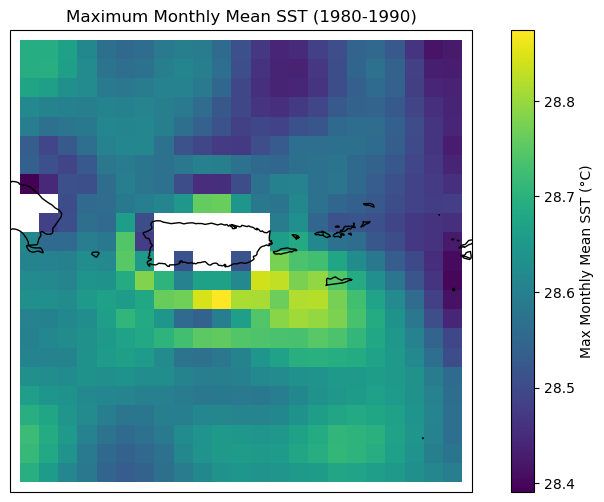

In [10]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
MMM.plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'Max Monthly Mean SST (°C)'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title("Maximum Monthly Mean SST (1980-1990)")
plt.show()

## Calculate DHW in 2 ways: using the standard 1°C threshold and using the variability based threshold (2*MMMstd; Boylan & Kleypas 2008)

In [17]:
# Use SST already in °C and masked
sst = ds.sst.where(mask)

# Expand MMM and std to match time dimension using broadcasting
MMM_expand = MMM.broadcast_like(sst)
MMM_std_expand = MMM_std.broadcast_like(sst)

# Define thresholds
threshold1 = MMM_expand + 1
threshold2 = MMM_expand + 2 * MMM_std_expand

# Hotspot anomalies (set values below threshold to 0), also avoid turning land pixels (nan) into 0.
hs_anoms1 = xr.where(~np.isnan(sst), xr.where(sst > threshold1, sst - threshold1, 0), np.nan)
hs_anoms2 = xr.where(~np.isnan(sst), xr.where(sst > threshold2, sst - threshold2, 0), np.nan)

# DHW = 12-week rolling sum, divided by 7 (to get °C-weeks)
DHW1 = hs_anoms1.rolling(valid_time=84, min_periods=84).sum() / 7
DHW2 = hs_anoms2.rolling(valid_time=84, min_periods=84).sum() / 7

# Mask again, just in case
DHW1 = DHW1.where(mask)
DHW2 = DHW2.where(mask)

# Add to dataset
ds['DHW1'] = DHW1
ds['DHW2'] = DHW2


In [18]:
# Run some checks:
print("SST max in 2024 is ", ds.sst.sel(valid_time='2024').max().values) # Is SST even exceeding threshold?

DHW1_2024 = DHW1.sel(valid_time=slice("2024-01-01", "2024-12-31"))
print("DHW1 max is ", DHW1_2024.max().values)

DHW2_2024 = DHW2.sel(valid_time=slice("2024-01-01", "2024-12-31"))
print("DHW2 max is ", DHW2_2024.max().values)

SST max in 2024 is  31.097565
DHW1 max is  9.659434


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: R

DHW2 max is  2.408202


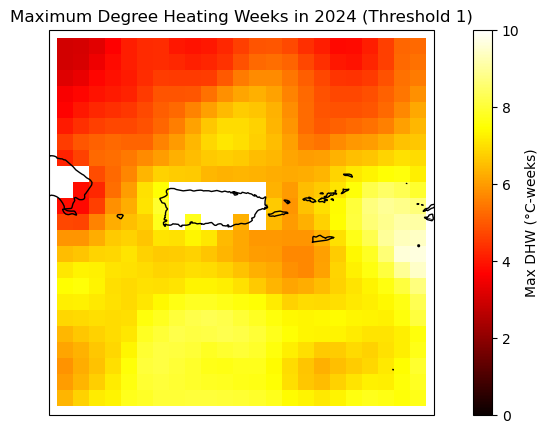

In [19]:
max_dhw_2024 = ds.DHW1.sel(valid_time='2024').max(dim='valid_time')
# Apply mask before plotting
masked_dhw = max_dhw_2024.where(mask)

cmap = colormaps['hot'].copy()
cmap.set_bad(color='white')

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot only where valid (ocean)
masked_dhw.plot(
    ax=ax,
    cmap=cmap,
    vmin=0,
    vmax=10,  
    cbar_kwargs={'label': 'Max DHW (°C-weeks)'}
)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')
ax.set_title("Maximum Degree Heating Weeks in 2024 (Threshold 1)")
plt.show()


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: R

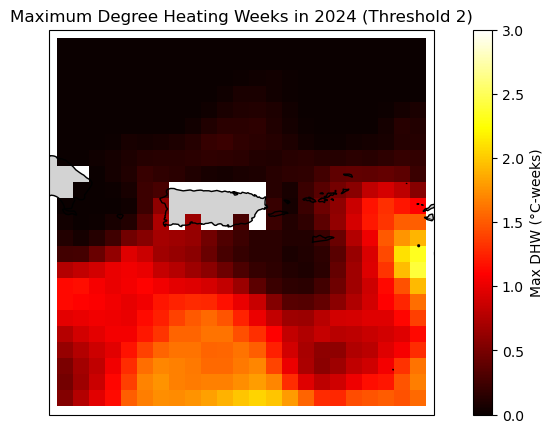

In [20]:
max_dhw_2024 = ds.DHW2.sel(valid_time='2024').max(dim='valid_time')
# Apply mask before plotting
masked_dhw = max_dhw_2024.where(mask)

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot only where valid (ocean)
masked_dhw.plot(
    ax=ax,
    cmap='hot',
    vmin=0,
    vmax=3,  
    cbar_kwargs={'label': 'Max DHW (°C-weeks)'}
)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray')
ax.set_title("Maximum Degree Heating Weeks in 2024 (Threshold 2)")
plt.show()


# Calculate max level of bleaching within each calendar year

In [27]:
# Extract years from valid_time
years = sst['valid_time'].dt.year

# Group by year
grouped1 = DHW1.groupby(years)
grouped2 = DHW2.groupby(years)

# Maximum DHW per year per coordinate
max_DHW1 = grouped1.max()
max_DHW2 = grouped2.max()

# Bleaching index = floor(max_DHW / 4)
bleach_index1 = np.floor(max_DHW1 / 4).astype(int)
bleach_index2 = np.floor(max_DHW2 / 4).astype(int)

# Number of days with DHW ≥ 4 per year per coordinate
bleach_days1 = grouped1.map(lambda x: (x >= 4).sum(dim='valid_time'))
bleach_days2 = grouped2.map(lambda x: (x >= 4).sum(dim='valid_time'))

# Put into Dataset
ds_bleach = xr.Dataset({
    'bleach_index1': bleach_index1,
    'bleach_index2': bleach_index2,
    'num_days_bleach1': bleach_days1,
    'num_days_bleach2': bleach_days2,
})

In [28]:
#### DHW1 ####

# Subset to years of interest (e.g., 1980–2024)
years = np.arange(1980, 2025)

# Group by year
dhw1_by_year = ds.DHW1.sel(valid_time=slice('1980-01-01', '2024-12-31')).groupby('valid_time.year')

# Compute max DHW per year and per grid cell
max_dhw1 = dhw1_by_year.max(dim='valid_time')

# Compute bleaching index (floor(max DHW / 4), like Coral Reef Watch)
bleach_index1 = np.floor(max_dhw1 / 4).astype(int)

# Replace NaNs (e.g., land) with 0
bleach_index1 = bleach_index1.where(~np.isnan(max_dhw1), other=np.nan)


ds_bleach = xr.Dataset()
ds_bleach['bleach_index1'] = bleach_index1

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/ar

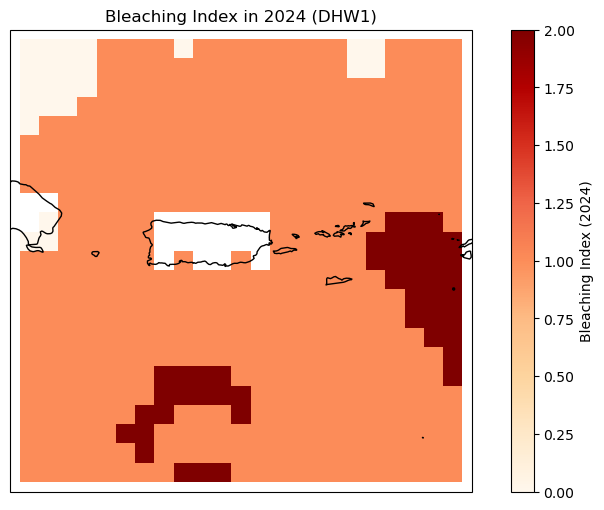

In [29]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
bleach_index1.sel(year=2024).plot(
    ax=ax, 
    cmap='OrRd', 
    cbar_kwargs={'label': 'Bleaching Index (2024)'}
)
ax.coastlines()
ax.set_title("Bleaching Index in 2024 (DHW1)")
plt.show()


In [25]:
#### DHW2 ####

# Subset to years of interest (e.g., 1980–2024)
years = np.arange(1980, 2025)

# Group by year
dhw2_by_year = ds.DHW2.sel(valid_time=slice('1980-01-01', '2024-12-31')).groupby('valid_time.year')

# Compute max DHW per year and per grid cell
max_dhw2 = dhw2_by_year.max(dim='valid_time')

# Compute bleaching index (floor(max DHW / 4), like Coral Reef Watch)
bleach_index2 = np.floor(max_dhw2 / 4).astype(int)

# Replace NaNs (e.g., land) with 0
bleach_index2 = bleach_index2.where(~np.isnan(max_dhw2), other=np.nan)


ds_bleach = xr.Dataset()
ds_bleach['bleach_index2'] = bleach_index2

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: R

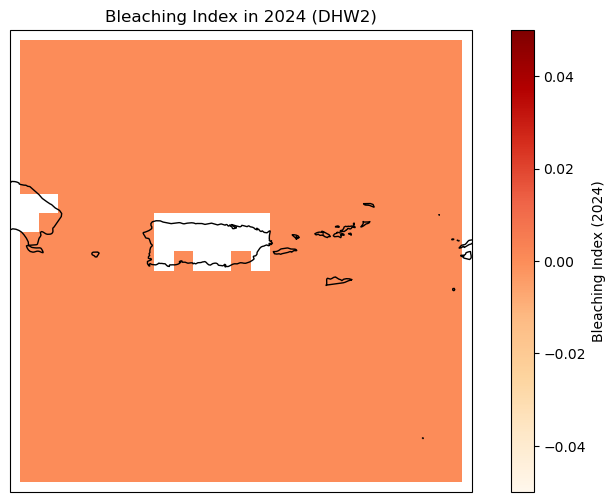

In [26]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
bleach_index2.sel(year=2024).plot(
    ax=ax, 
    cmap='OrRd', 
    cbar_kwargs={'label': 'Bleaching Index (2024)'}
)
ax.coastlines()
ax.set_title("Bleaching Index in 2024 (DHW2)")
plt.show()
